In [1]:
from utils import generate_world_pandas, generate_world_bounds, generate_world
import ploting as draw
import random
import numpy as np
import pandas as pd

In [2]:
def generate_true_values(seed, class_with_bounds,
                         no_samples = 10**4,
                         equal_classes = False):
    random.seed(seed)
    points = []
        
    if equal_classes:
        for cls in class_with_bounds.keys():
            for _ in range(no_samples):
                val = [random.uniform(minV, maxV) for minV, maxV in random.choice(list(class_with_bounds[cls]))]
                points.append(np.array([cls] + val))
    else:
        bounds_set = set()
        for b in class_with_bounds.values():
            bounds_set |= b
        for _ in range(no_samples):
            bound = random.choice(list(bounds_set))
            for cls, bounds in class_with_bounds.items():
                if bound in bounds:
                    break
            val = [random.uniform(minV, maxV) for minV, maxV in bound]
            points.append(np.array([cls] + val))
    return np.array(points)

def add_unc(tv, correlation, errRange):
    error = np.random.uniform(-errRange, errRange, tv.shape)
    obs = tv + error
    X = np.abs(error)
    
    if errRange == 0: # To ensure not to have nan in uncertainty vector. If error_range is 0, set Uncertainty directly to 0
        Y = np.zeros_like(X)
    
    else:
        # Standardize X
        X_standardized = (X - X.mean()) / X.std()
        
        # Generate Z such that correlation is maintained
        Z = np.random.uniform(0, 1, X.shape)
        Z_standardized = (Z - Z.mean()) / Z.std()
        
        # Create Y with the specified correlation
        Y_standardized = correlation * X_standardized + np.sqrt(1 - correlation**2) * Z_standardized
        
        # Scale Y back to the original scale of X
        Y = Y_standardized * X.std() + X.mean()
        
        # Calculate the uncertainty Y = ZX
        Y = Y * X.mean()  # Adjust Y with the mean of X to ensure scaling
    
    # Add the calculated uncertainty to the dataset
    unc = Y.astype(np.float32)

    return np.array([obs, unc, error])

def data_to_world(data, errRange = 1, corr = 1):
    _, n_feat = data.shape
    n_feat -= 1
    args = {
        "errRange": errRange,
        "correlation" : corr
    }
    arr = []
    i = 0
    arr.append(data[:, i])
    i += 1
    for _ in range(n_feat):
        arr.append(data[:, i])
        i += 1

    for i in range(n_feat):
        ov_unc_err = add_unc(data[:, i + 1], **args)
        arr.append(ov_unc_err[0]) 
        arr.append(ov_unc_err[1])
        arr.append(ov_unc_err[2])

    #Class, True Value 1, True Value 2, Observed Value 1, Uncertainty 1, Error 1, Observed Value 2, Uncertainty 2, Error 2
    return np.stack(arr, axis=1)


In [3]:
def generate_world(world_seed, data_seed, features,
                   no_samples = 10**4,
                   equal_classes = False,
                   feature_bounds = (0, 1),
                   endArea = .3,
                   endThreshold = .2,
                   max_depth = 4,
                   class_number = 2,
                   errRange = 0.1,
                   corr = 1):

    args = {"features": features,
            "feature_bounds": feature_bounds,
            "endThreshold": endThreshold,
            "endArea": endArea,
            "max_depth": max_depth,
            }
    
    random.seed(world_seed)
    world_coords = generate_world_bounds(**args)
    
    from collections import defaultdict
    class_with_bounds = defaultdict(set)
    random_list = list(np.arange(class_number)) + [random.randint(0, class_number - 1) for _ in range(len(world_coords) - class_number)]
    random.shuffle(random_list)
    for i, bounds in zip(random_list, world_coords):
        class_with_bounds[i] |= {bounds}
    
    data = generate_true_values(data_seed, class_with_bounds, no_samples, equal_classes)
    
    np.random.seed(data_seed)
    return data_to_world(data, errRange = errRange, corr = corr)

def generate_world_pandas(world_seed, data_seed, features,
                   no_samples = 10**4,
                   equal_classes = False,
                   feature_bounds = (0, 1),
                   endArea = .3,
                   endThreshold = .2,
                   max_depth = 4,
                   class_number = 2,
                   errRange = 0.1,
                   corr = 1):
    
    data = generate_world(world_seed, data_seed, features,
                          no_samples = no_samples,
                          equal_classes = equal_classes,
                          feature_bounds = feature_bounds,
                          endArea = endArea,
                          endThreshold = endThreshold,
                          max_depth = max_depth,
                          class_number = class_number,
                          errRange = errRange,
                          corr = corr)
    
    columns = ["Class"] + [f"True Value {feature}" for feature in range(1, features + 1)]
    for feature in range(1, features + 1):
        columns += [f"Observed Value {feature}", f"Uncertainty {feature}", f"Error {feature}"]
        
    df = pd.DataFrame(data, columns=columns)
    return df


In [4]:
def add_noise_old(tv, errRange = 1, mutation_rate = 0):
    
    def add_unc_single_value(tv, errRange, mutation_rate):
        rv = random.random() if random.random() < mutation_rate else tv 
        rv += errRange * random.uniform(-1, 1)
        return rv
    
    def add_unc_array(tv, errRange, mutation_rate):
        rv = []
        for t in tv:
            rv.append(add_unc_single_value(t, errRange, mutation_rate))
        return np.array(rv)
    
    try:
        iter(tv)
    except:
        _add_unc = add_unc_single_value
    else:
        _add_unc = add_unc_array
    
    return _add_unc(tv, errRange, mutation_rate)

In [5]:
def add_noise(world, errRange = 1, mutation_rate = 0):
    _, n_feat = world[:, 1:].shape
    for i, cls_feat in enumerate(world):
        mutation = True if random.random() < mutation_rate else False
        if mutation:
            for j in range(1, n_feat + 1):
                cls_feat[j] = random.random() + errRange * random.uniform(-1, 1)
        else:
            for j in range(1, n_feat + 1):
                cls_feat[j] += errRange * random.uniform(-1, 1)
        world[i] = cls_feat
    return world

In [6]:
import matplotlib.pyplot as plt

def draw_combined_world(data, sample_data = None, cmap='viridis'):    
    # Extracting data for the true world
    true_classes = data[:, 0]
    true_f1 = data[:, 1]
    true_f2 = data[:, 2]
    
    # Extracting data for the observed worlds
    real_f1 = data[:, 3]
    real_f2 = data[:, 4]
    
    minf1 = np.min([true_f1, real_f1])
    maxf1 = np.max([true_f1, real_f1])
    minf2 = np.min([true_f2, real_f2])
    maxf2 = np.max([true_f2, real_f2])
    
    # Creating subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        
    axs[0].set_xlim(minf1, maxf1)
    axs[1].set_xlim(minf1, maxf1)
    
    axs[0].set_ylim(minf2, maxf2)
    axs[1].set_ylim(minf2, maxf2)
    
    # True World
    axs[0].scatter(true_f1, true_f2, c=true_classes, cmap=cmap, edgecolor='k', marker='s')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    axs[0].set_title('True World')
    
    # Observed World
    axs[1].scatter(real_f1, real_f2, c=true_classes, cmap=cmap, edgecolor='k', marker='s')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    axs[1].set_title('Real World')
    
    plt.tight_layout()
    
    # Display the plot
    plt.show()

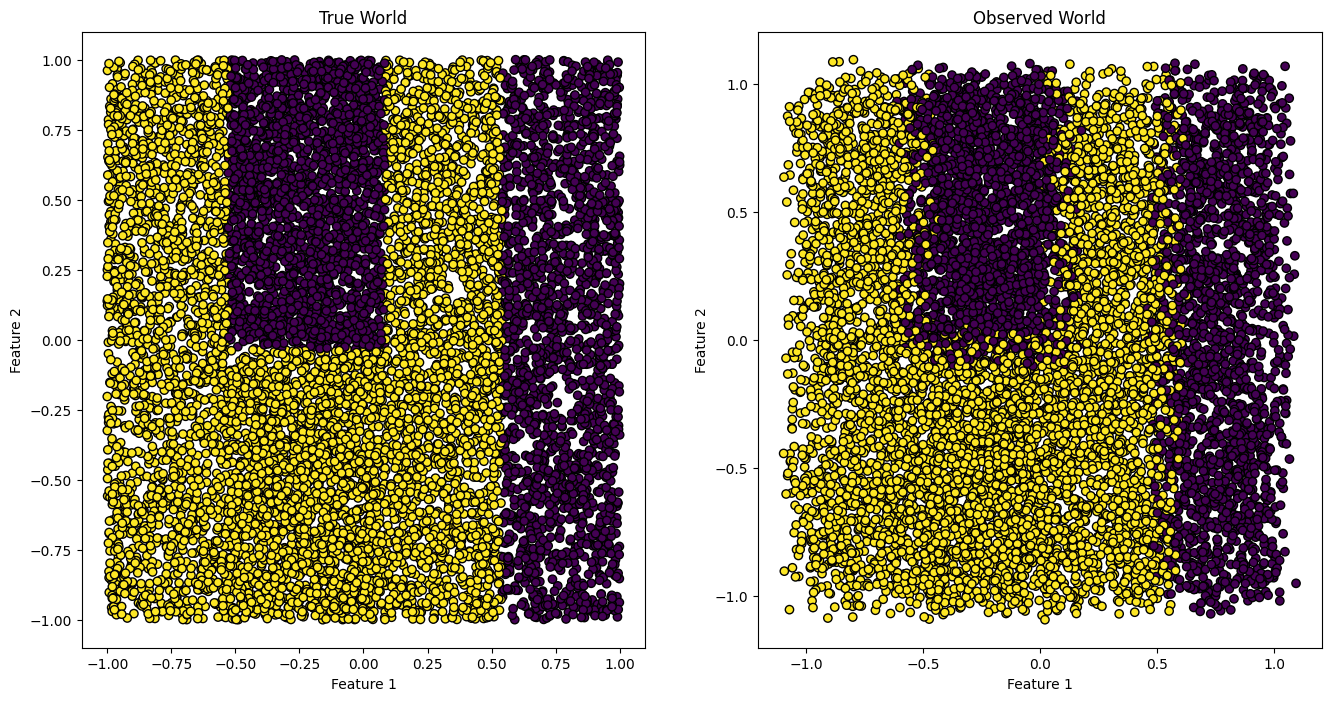

In [15]:
world = generate_world(1, 0, 2, no_samples=10000,feature_bounds=(-1, 1), equal_classes=False, errRange=0.1, corr=0.1)
# print(world)
# world = add_noise(world, errRange=0.05, mutation_rate=0.1)
# r = 0.9
# y1 = r*world[:, 1]+np.sqrt(1-r*r)*world[:, 1] 
# world = np.c_[world, add_noise(world[:, 1], errRange=0.05, mutation_rate=0.1)]
# world = np.c_[world, add_noise(world[:, 2], errRange=0.05, mutation_rate=0.1)]

# world[:, 1] = add_noise(world[:, 1], errRange=0.05, mutation_rate=0.1)
# world[:, 2] = add_noise(world[:, 2], errRange=0.05, mutation_rate=0.1)

# print(np.corrcoef(world[:, 1], world[:, 3])[0, 1])
draw.draw_combined_world(world)

In [23]:
world = generate_world_pandas(1, 0, 2, no_samples=20,feature_bounds=(-1, 1), equal_classes=False, errRange=0.1, corr=1)

In [24]:
world

,Class,True Value 1,True Value 2,Observed Value 1,Uncertainty 1,Error 1,Observed Value 2,Uncertainty 2,Error 2
0,0.0,0.888684,-0.158857,0.898446,0.000467,0.009763,-0.186955,0.001263,-0.028098
1,1.0,0.524318,-0.028145,0.567355,0.002059,0.043038,-0.040738,0.000566,-0.012594
2,1.0,0.525385,-0.283901,0.545938,0.000983,0.020553,-0.244375,0.001777,0.039526
3,0.0,-0.219517,0.257919,-0.210540,0.000430,0.008977,0.169964,0.003955,-0.087955
4,1.0,-0.708009,-0.498987,-0.723278,0.000731,-0.015269,-0.465634,0.001500,0.033353
5,1.0,0.072529,-0.216768,0.101708,0.001396,0.029179,-0.182640,0.001535,0.034128
6,0.0,-0.338351,0.720834,-0.350833,0.000597,-0.012483,0.662910,0.002605,-0.057923
7,1.0,0.298841,-0.798598,0.377196,0.003749,0.078355,-0.872812,0.003337,-0.074215
8,0.0,0.685520,0.280847,0.778253,0.004437,0.092733,0.243932,0.001660,-0.036914
9,0.0,0.062646,0.459591,0.039334,0.001115,-0.023312,0.432333,0.001226,-0.027258


In [25]:
np.corrcoef(np.abs(world["Error 1"]), world["Uncertainty 1"])[0,1]

0.999999999999999